In [2]:
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import quantile_transform

%matplotlib inline

In [4]:
full = pd.read_csv('data/gen_1_holes.csv', index_col = 0)
# full = pd.read_csv('data/CA1_6_1_clean.csv', index_col = 0)

In [5]:
full.head()

,0N,1N,2N,3N,4N,5N,6N,7N,8N,9N,...,193N,194N,195N,196N,197N,198N,199N,x,y,ang
0,6.137285,6.097568,7.981179,2.657686,8.919547,4.274941,5.179740,3.329182,1.932031,0.178958,...,0.052298,1.043834,0.758416,0.041510,0.570631,0.361448,0.879365,0.316915,0.037568,-1.947778
1,1.128934,6.372495,10.931732,5.148409,4.566580,7.450268,3.145072,2.717946,1.464976,2.153725,...,0.177679,1.146309,0.179111,1.535442,0.826470,0.002301,0.435258,0.397302,0.084844,-1.813300
2,0.853555,3.371220,9.012780,3.539809,6.774548,10.779202,2.431839,1.256614,2.002973,0.709518,...,0.098760,1.443941,0.464352,0.682519,0.280986,0.235136,0.557921,0.449147,0.079035,-1.691014
3,0.699315,5.615830,5.725598,2.757512,3.292234,13.453683,6.159488,2.802111,1.799720,1.586054,...,0.213535,0.937239,0.383083,0.716624,0.692223,0.140585,0.121586,0.474667,0.057570,-1.627992
4,2.934969,0.965006,2.585714,4.674477,6.684643,6.955064,10.598396,7.053686,1.640949,5.961785,...,0.171356,1.847330,0.162991,0.130131,1.095337,1.971624,1.846373,0.540623,0.028656,-1.484823


In [7]:
full = full.drop(['x','y', 'ang'], axis=1)
# full = full.drop(['x','y', 'segment'], axis=1)

In [ ]:
import json

with open('data/lr_neurons.json') as f:
    neurons = json.load(f)

In [ ]:
full = full.loc[:, neurons]

In [ ]:
#mis = pd.read_csv('data/gen_mi_best_neurons.csv', index_col=0);
#mis['neuron'] = mis.index

In [ ]:
import gc

In [22]:
from dionysus import Filtration, homology_persistence, init_diagrams, Simplex
from collections import Counter
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def get_cycles_for_filtration(filtration, end_time=np.inf):
    m = homology_persistence(filtration, prime=2, progress=True)
    dgms = init_diagrams(m, filtration)
    cycles = []
    for i, dgm in enumerate(dgms):
        for pt in dgm:
            cycles.append((i, pt.birth, pt.death))
            #print((i, pt.birth,pt.death))
    cycles = pd.DataFrame(cycles, columns=['dimension', 'birth_time', 'death_time'])
    cycles['living_time'] = cycles['death_time'] - cycles['birth_time']
    inf_life = (cycles['living_time'] == np.inf)
    cycles['living_time'][inf_life] = end_time - cycles['birth_time'][inf_life]
    return cycles.sort_values('dimension', ascending=True)



def homologies(df, number_of_ap):
    # time - simplexes that live > time%
    # number_of_ap = (time/100) * len(df)
    #number_of_ap=90
    #print(number_of_ap)

    df = quantile_transform(df)
    time = 10
    filtration = Filtration()
    cnt = 0
    for alpha in np.arange(0.50, 0.99, 0.05):
        neuron_activity = df > alpha
        
        complexes = []
        sims = np.sum(neuron_activity * (2**np.arange(neuron_activity.shape[1])), axis=1)
        for sim, cnt in Counter(sims).items():
            if cnt > number_of_ap:
                complexes.append(np.where(np.array(list(bin(int(sim))[2:][::-1])) == '1')[0])
        
        del sims
        
        all_simplexes = []
        for compl in complexes:
            for s in list(powerset(compl))[1:]:
                all_simplexes.append(s)
                
                
        print(alpha, len(all_simplexes))
        for sim in all_simplexes:
            filtration.append(Simplex(sim, alpha))
        del all_simplexes
#         gc.collect(0)
#         gc.collect(1)
#         gc.collect(2)
        #print()
    cycles = get_cycles_for_filtration(filtration, 0.95)
    cycles.columns = [f"{col}_{number_of_ap/df.shape[0]}" for col in cycles.columns]
    
    return cycles.reset_index(drop=True)

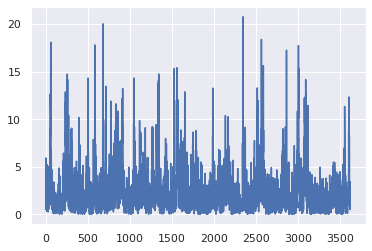

In [23]:
plt.plot(full['60N'])

In [24]:
full = full.iloc[:, :61]

In [ ]:
for n in [50, 60, 70, 80, 90, 100, 200, 500][:1]:
    print(n)
    #mi_best_neurons = mis[:10]['neuron']
    #data = full.drop(['x', 'y'], axis=1)[mi_best_neurons.index]
    df = homologies(full[:500], n)
    print(df.T)
    print()